# Housekeeping

In [522]:
import os
import glob
import sys

import numpy as np
import pandas as pd
import os.path as path
from scipy import misc, stats
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import cv2

import pathlib

from keras.models import Sequential, save_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
from keras.utils import to_categorical # For keras > 2.0
from keras.callbacks import ReduceLROnPlateau


%matplotlib inline

In [436]:
IMG_SIZE = (100,100)
N_SAMPLE = 600 # how many to sample from each class (classes w/ <N will be dropped)
N_CLASSES = 5 # how many asanas to classify
TRAIN_TEST_SPLIT = 0.8

# DATA PREPROCESSING

In [437]:
# list all image files
filepaths = glob.glob('dataset/google/*/*')
filepaths = [x for x in filepaths if os.path.splitext(x)[1]!='.json']
print(len(filepaths))
filepaths[0:10]

71379


['dataset/google/Setu+Bandha+Sarvangasana/Scrapper_297.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_241.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_295.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_83.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_337.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_111.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_312.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_345.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_19.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_167.jpg']

In [438]:
# create dataframe of filenames
filepaths_df = pd.DataFrame({'path': filepaths,\
                            'label': [x.split('/')[2] for x in filepaths]})

print(filepaths_df.shape)
filepaths_df.head()

(71379, 2)


,label,path
0,Setu+Bandha+Sarvangasana,dataset/google/Setu+Bandha+Sarvangasana/Scrapp...
1,Setu+Bandha+Sarvangasana,dataset/google/Setu+Bandha+Sarvangasana/Scrapp...
2,Setu+Bandha+Sarvangasana,dataset/google/Setu+Bandha+Sarvangasana/Scrapp...
3,Setu+Bandha+Sarvangasana,dataset/google/Setu+Bandha+Sarvangasana/Scrapp...
4,Setu+Bandha+Sarvangasana,dataset/google/Setu+Bandha+Sarvangasana/Scrapp...


In [503]:
# drop those classes with <N_SAMPLE labels
# pick N_CLASSES of those remaining 

cnt = filepaths_df.groupby('label', as_index=False)['path'].count()
lbls = cnt[cnt.path>=N_SAMPLE].label.tolist() # pick only those w/ cnt>N_SAMPLE
lbls = random.sample(lbls,N_CLASSES) # pick randomly N_CLASSES
mask = filepaths_df['label'].isin(lbls)
filepaths_df = filepaths_df[mask]


# print filepaths_df.shape
# filepaths_df.head()

In [504]:
cnt#[cnt.path==cnt.path.min()]

,label,path
0,Dhyana,673
1,Savasana,688
2,Supta+Balasana,614
3,Svara+Yoga+Pranayama,704
4,Ustrasana,606


In [440]:
# sample N_SAMPLE per group
filepaths_sample_df = filepaths_df.groupby('label').apply(lambda x: \
                                        x.sample(N_SAMPLE)).reset_index(drop=True)
print(filepaths_sample_df.shape)
filepaths_sample_df.head()

(3000, 2)


,label,path
0,Dhyana,dataset/google/Dhyana/Scrapper_626.jpg
1,Dhyana,dataset/google/Dhyana/Scrapper_256.jpg
2,Dhyana,dataset/google/Dhyana/Scrapper_624.jpg
3,Dhyana,dataset/google/Dhyana/Scrapper_653.jpg
4,Dhyana,dataset/google/Dhyana/Scrapper_5.jpg


In [441]:
# Load the images, drop failed loads from df

images=[]
for i in range(len(filepaths_sample_df.path)):
    path = filepaths_sample_df.path[i]
    try:
        images.append(misc.imread(path))
    except:
        print "Failed to read in: %s, Dropping from dataframe" % path
        filepaths_sample_df = filepaths_sample_df.drop(i)
print
print("Number of images loaded: %d" %len(images))
print("Number of images in df: %d" %filepaths_sample_df.shape[0])

Failed to read in: dataset/google/Dhyana/Scrapper_402.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_619.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_110.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_515.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_280.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_124.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_603.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_50.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_632.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_580.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_251.jpg, Dropping from dataframe
Failed to read in: dataset/google/Dhyana/Scrapper_170.jpg, Dropping from dataframe
Faile

In [442]:
# (1) Scale image arrays s.t range is between 0 and 1 instea dof 0 and 255
# (2) Resize to be of dim IMG_SIZE (width,height)
# When the normType is NORM_MINMAX, cv::normalize normalizes _src in such a way that 
#   the min value of dst is alpha and max value of dst is beta. cv::normalize does its magic 
#   using only scales and shifts (i.e. adding constants and multiplying by constants).
# (3) Drop fourth dimmension for PNG images
# (4) create 3rd dim for greay scale imges
i=random.randint(0, len(images))
print("Showing sample results for scaling/reszing of image %d, %s" % \
      (i,filepaths_sample_df.path[i]))
print
print "..... BEFORE:"
print images[i].shape
print images[i][:,:,0].shape
print stats.describe(images[i][:,:,0].flatten())
print

images_sc = [None] * len(images)
for j in range(len(images)):
    if j % 250 == 0:
        print "Processed %d images..." % j
    if images[j].all()==None:
        images_sc[j]=None
    else:
        try:
            temp = images[j]
            if len(temp.shape) > 2 and temp.shape[2] == 4: # PNG rgb images have 4 channels
                temp = cv2.cvtColor(temp, cv2.COLOR_BGRA2BGR)
            elif len(temp.shape) > 2 and temp.shape[2] == 2: # PNG grsc images have 2 channels
                temp = np.stack((temp[:,:,0],)*3, -1)
            elif len(temp.shape) == 2: # grsc images have 1 channel
                temp = np.stack((temp,)*3, -1)
            temp = cv2.resize(temp.astype('uint8'), dsize=IMG_SIZE)
            temp = cv2.normalize(temp, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, \
                                 dtype=cv2.CV_32F, dst=None)
            images_sc[j] = temp
        except:
            print "Unexpected error:", sys.exc_info()[0]

print   
print "..... AFTER:"     
print images_sc[i].shape
print images_sc[i][:,:,0].shape
print stats.describe(images_sc[i][:,:,0].flatten())

Showing sample results for scaling/reszing of image 2217, dataset/google/Svara+Yoga+Pranayama/Scrapper_445.jpg

..... BEFORE:
(283, 180, 3)
(283, 180)
DescribeResult(nobs=50940, minmax=(0, 255), mean=229.476423243031, variance=1501.5965897311469, skewness=-3.0836850610053985, kurtosis=10.807348496126243)

Processed 0 images...
Processed 250 images...
Processed 500 images...
Processed 750 images...
Processed 1000 images...
Processed 1250 images...
Processed 1500 images...
Processed 1750 images...
Processed 2000 images...
Processed 2250 images...
Processed 2500 images...
Processed 2750 images...

..... AFTER:
(100, 100, 3)
(100, 100)
DescribeResult(nobs=10000, minmax=(0.003921569, 1.0), mean=0.8987503, variance=0.022363525, skewness=-3.04746413230896, kurtosis=10.699436528348434)


In [443]:
# Split at the given index
n_images = len(images_sc)
labels = filepaths_sample_df.label.tolist()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

paths = filepaths_sample_df.path.tolist()
print("There are %d images loaded and %d labels" % \
      (n_images,len(labels)))
print

split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = np.array([images_sc[i] for i in train_indices])
y_train = np.array([dummy_y[i] for i in train_indices])
paths_train = [paths[i] for i in train_indices]
print("... of which %d are train images loaded and %d train labels" % \
      (x_train.shape[0],y_train.shape[0]))
print

x_test = np.array([images_sc[i] for i in test_indices])
y_test = np.array([dummy_y[i] for i in test_indices])
paths_test = [paths[i] for i in test_indices]
print("... of which %d train images loaded and %d train labels" % \
      (x_test.shape[0],y_test.shape[0]))

There are 2974 images loaded and 2974 labels

... of which 2379 are train images loaded and 2379 train labels

... of which 595 train images loaded and 595 train labels


dataset/google/Savasana/Scrapper_156.jpg


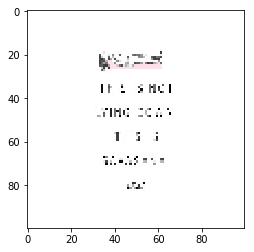

In [497]:
i=random.randint(0, x_train.shape[0])
print paths_train[i]
plt.imshow(x_train[i])


In [470]:
def visualize_data(positive_images, negative_images):
    # INPUTS
    # positive_images - Images where the label = 1 (True)
    # negative_images - Images where the label = 0 (False)

    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()

In [445]:
# # Number of positive and negative examples to show
# N_TO_VISUALIZE = 10

# # Select the first N positive examples
# positive_example_indices = (y_train == 1)
# positive_examples = x_train[positive_example_indices, :, :]
# positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

# # Select the first N negative examples
# negative_example_indices = (y_train == 0)
# negative_examples = x_train[negative_example_indices, :, :]
# negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

# # Call the visualization function
# visualize_data(positive_examples, negative_examples)

In [446]:
# ## MODEL CREATION ##
# # Imports
# # Model Hyperparamaters
# N_LAYERS = 4

# def cnn(size, n_layers, n_classes):
#     # INPUTS
#     # size     - size of the input images
#     # n_layers - number of layers
#     # OUTPUTS
#     # model    - compiled CNN

#     # Define model hyperparamters
#     MIN_NEURONS = 20
#     MAX_NEURONS = 120
#     KERNEL = (3, 3)

#     # Determine the # of neurons in each convolutional layer
#     steps = np.floor(MAX_NEURONS / (n_layers + 1))
#     nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
#     nuerons = nuerons.astype(np.int32)

#     # Define a model
#     model = Sequential()

#     # Add convolutional layers
#     for i in range(0, n_layers):
#         if i == 0:
#             shape = (size[0], size[1], size[2])
#             model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
#         else:
#             model.add(Conv2D(nuerons[i], KERNEL))

#         model.add(Activation('relu'))

#     # Add max pooling layer with dropout
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
# #     model.add(Dense(MAX_NEURONS))
# #     model.add(Activation('relu'))

#     # Add output layer
# #     model.add(Dense(1))
# #     model.add(Activation('sigmoid'))
#     model.add(Flatten())
#     model.add(Dense(256, activation = "relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(n_classes, activation = "softmax"))

#     # Compile the model
# #     model.compile(loss='binary_crossentropy',
# #                   optimizer='adam',
# #                   metrics=['accuracy'])
#     optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#     model.compile(optimizer = optimizer , \
#               loss = "categorical_crossentropy", \
#               metrics=["accuracy"])

#     # Print a summary of the model
#     model.summary()

#     return model

In [447]:
# Instantiate the model
image_size = x_train[0].shape
n_classes = y_train.shape[1]
# model = cnn(size=image_size, n_layers=N_LAYERS, n_classes=n_classes)

In [448]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86

img_rows, img_cols = IMG_SIZE

nb_filters_1 = 32 
nb_filters_2 = 64 
nb_filters_3 = 128 

nb_conv = 3 # kernel_size dim
nb_classes = y_train.shape[1]

In [449]:
model1 = Sequential()
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = image_size))
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes, activation = "softmax"))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
__________

In [450]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model1.compile(optimizer = optimizer , \
              loss = "categorical_crossentropy", \
              metrics=["accuracy"])

In [451]:
## MODEL TRAINING ##
# Training Hyperparamters
EPOCHS = 5
BATCH_SIZE = 200

# Early stopping callback
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')

# TensorBoard callback
LOG_DIRECTORY_ROOT = 'logdir'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

# Place the callbacks in a list
callbacks = [early_stopping, tensorboard]

In [452]:
# Train the model
model1.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,\
          callbacks=callbacks, verbose=2)

Epoch 1/5
 - 59s - loss: 2.5611 - acc: 0.2114
Epoch 2/5
 - 58s - loss: 2.3321 - acc: 0.2215
Epoch 3/5
 - 58s - loss: 1.9752 - acc: 0.2215
Epoch 4/5
 - 59s - loss: 1.6849 - acc: 0.2186
Epoch 5/5
 - 58s - loss: 1.6120 - acc: 0.2182


In [526]:
# Save Model

MODEL_DIRECTORY_ROOT = 'modeldir'
model_dir = "{}/run-{}/".format(MODEL_DIRECTORY_ROOT, now)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
 
save_model(model1, model_dir+'model.h5', overwrite=True,include_optimizer=True)

In [527]:
## MODEL EVALUATION ##
# Make a prediction on the test set
test_predictions = model1.predict(x_test)
test_predictions = np.round(test_predictions)

In [528]:
print x_test.shape
print test_predictions.shape
print stats.describe(test_predictions)

(595, 100, 100, 3)
(595, 5)
DescribeResult(nobs=595, minmax=(array([0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0.], dtype=float32)), mean=array([0., 0., 0., 0., 0.], dtype=float32), variance=array([0., 0., 0., 0., 0.], dtype=float32), skewness=array([0., 0., 0., 0., 0.], dtype=float32), kurtosis=array([-3., -3., -3., -3., -3.], dtype=float32))


In [530]:
test_predictions[200]

array([0., 0., 0., 0., 0.], dtype=float32)

In [531]:
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


TypeError: Invalid dimensions for image data

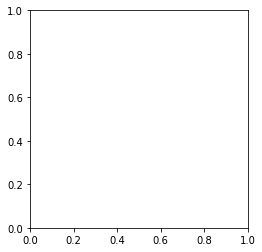

In [532]:
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())